In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

/opt/sci-soft/software/Python/3.6.1-foss-2016b/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Importamos el dataset con pandas

In [2]:
dataset = pd.read_csv('ar_filt_dataset.csv')
dataset.sample(frac=1) # Esto reordena las filas de los datasets
X = dataset.iloc[:, :-1].values # Variables independientes (analitos)
y = dataset.iloc[:, -1].values # Variable dependiente (Caso/Control)

### Creación de los conjuntos train y test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 0)

### Escalamos los conjuntos train y test

In [4]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### Feature importance

In [5]:
analytes = list(dataset.columns)
analytes.pop()

'Group'

In [6]:
model = ExtraTreesClassifier(n_estimators=np.size(X_train, 1), random_state=0)
model.fit(X_train, y_train)
importance_df = pd.DataFrame(
    {'Analytes': analytes,
    'Importance': model.feature_importances_,})
importance_df.sort_values('Importance', ascending=False)

,Analytes,Importance
6,Vimentin.cit,0.144403
11,Histone.2A..1.20..cit.cyclic,0.121463
1,Enolase.1A..5.21..cit,0.100255
10,Histone.2B..62.81..cit.cyclic,0.085960
2,Fibrinogen.A,0.077484
8,Fibrinogen.A..616.635..cit3.cyclic,0.076312
3,Cfc..48.65..cit.cyclic,0.075253
4,Fibrinogen.A.cit,0.074802
9,Fibrinogen.A..41.60..cit3.cyclic,0.072682
7,Histone.2B,0.060381


In [ ]:
X_train = X_train[:, [6, 11, 1, 10, 2, 8, 3]]
X_test = X_test[:, [6, 11, 1, 10, 2, 8, 3]]

#### Ajustes del modelo basándonos en RocAuc

In [ ]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=LogisticRegression(random_state = 0),
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

#### Entrenamiento del modelo

In [7]:
classifier = LogisticRegression(C = 10, random_state=0, class_weight = {1: 0.6, 0: 0.4})
classifier.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={1: 0.6, 0: 0.4}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Resultados de predicción

In [8]:
y_pred = classifier.predict(X_test)

In [9]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm)

,0,1
0,55,15
1,21,49


In [10]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = classifier.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

In [11]:
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
pd.DataFrame({
    "Accuracy_test": [accuracy],
    "Precision_test": [precision],
    "Roc_AUC": [lr_auc]
})

,Accuracy_test,Precision_test,Roc_AUC
0,0.742857,0.744655,0.812449


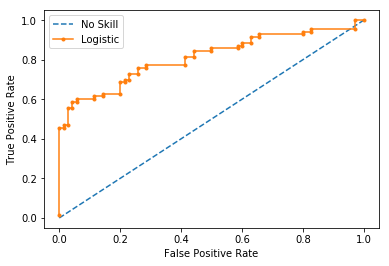

In [12]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()